In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import rasterio
#from rasterio.mask import maskn
from shapely.geometry import Point, LineString
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load roads (for can and pedestrian) network data for Washington DC
place = 'Montgomery County, Maryland, USA'
G = ox.graph_from_place(place, network_type='all')

In [4]:
# Convert the network into a GeoDataFrame
gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [5]:
gdf_edges

osmid  oneway  \
u           v          key                                              
272629      293014444  0    [243238592, 945506513, 469085700]    True   
            293007144  0                            874712241    True   
281233      281236     0              [972276888, 1049923944]    True   
281236      290721328  0              [991413856, 1050237307]    True   
281247      290049325  0                            124083353    True   
...                                                       ...     ...   
12109077617 1037989017 0                             89533984   False   
            1037989047 0                             89533984   False   
12109077622 1036605197 0                             89380181   False   
            7376986847 0                             89380181   False   
            1037986541 0             [1307585052, 1307585053]   False   

                                lanes        highway reversed   length  \
u           v          key                                               
272629      293014444  0    [3, 2, 1]  motorway_link    False  300.271   
            293007144  0            4       motorway    False  329.393   
281233      281236     0       [3, 4]       motorway    False  397.971   
281236      290721328  0            4       motorway    False  746.198   
281247      290049325  0            6       motorway    False  139.136   
...                               ...            ...      ...      ...   
12109077617 1037989017 0          NaN        footway    False   55.575   
            1037989047 0          NaN        footway     True   73.709   
12109077622 1036605197 0          NaN        footway    False    3.708   
            7376986847 0          NaN        footway     True  433.322   
            1037986541 0          NaN        footway     True   10.861   

                                                                     geometry  \
u           v          key                                                      
272629      293014444  0    LINESTRING (-77.03783 39.01344, -77.03952 39.0...   
            293007144  0    LINESTRING (-77.03783 39.01344, -77.03860 39.0...   
281233      281236     0    LINESTRING (-77.14293 39.02126, -77.14227 39.0...   
281236      290721328  0    LINESTRING (-77.14168 39.02468, -77.14158 39.0...   
281247      290049325  0    LINESTRING (-77.14465 39.03661, -77.14531 39.0...   
...                                                                       ...   
12109077617 1037989017 0    LINESTRING (-77.02456 39.02963, -77.02444 39.0...   
            1037989047 0    LINESTRING (-77.02456 39.02963, -77.02468 39.0...   
12109077622 1036605197 0    LINESTRING (-77.02767 39.02918, -77.02767 39.0...   
            7376986847 0    LINESTRING (-77.02767 39.02918, -77.02756 39.0...   
            1037986541 0    LINESTRING (-77.02767 39.02918, -77.02762 39.0...   

                                   ref             name maxspeed bridge  \
u           v          key                                                
272629      293014444  0           NaN              NaN      NaN    NaN   
            293007144  0         I 495  Capital Beltway   55 mph    NaN   
281233      281236     0    I 270 Spur              NaN   55 mph    NaN   
281236      290721328  0    I 270 Spur              NaN   55 mph    NaN   
281247      290049325  0         I 270              NaN      NaN    NaN   
...                                ...              ...      ...    ...   
12109077617 1037989017 0           NaN              NaN      NaN    NaN   
            1037989047 0           NaN              NaN      NaN    NaN   
12109077622 1036605197 0           NaN              NaN      NaN    NaN   
            7376986847 0           NaN              NaN      NaN    NaN   
            1037986541 0           NaN              NaN      NaN    NaN   

                           service junction width access tunnel  
u           v          key                     

In [6]:
# Function to handle Table 1: Imputation of Roadway Characteristics
def Table1(row):
    highway = row['highway']
    lanes = row['lanes']
    maxspeed = row['maxspeed']
    
    # Handle lists in 'lanes' and 'maxspeed'
    if isinstance(lanes, list):
        lanes = lanes[0]  # Take the first element or calculate an average
    
    if isinstance(maxspeed, list):
        maxspeed = maxspeed[0]  # Take the first element or calculate an average
    
    # Set default values if not available
    if pd.isna(lanes):
        if highway == 'residential':
            lanes = 2
        elif highway == 'unclassified':
            lanes = 2
        elif highway == 'tertiary':
            lanes = 3
        elif highway == 'track':
            lanes = 2
        elif highway == 'secondary':
            lanes = 4
        elif highway == 'primary':
            lanes = 6
        elif highway == 'trunk' or highway == 'motorway':
            lanes = 6
        else:
            lanes = 2  # Default for OTHER

    if pd.isna(maxspeed):
        if highway == 'residential' or highway == 'unclassified':
            maxspeed = 25
        elif highway == 'tertiary':
            maxspeed = 30
        elif highway == 'track':
            maxspeed = 30
        elif highway == 'secondary':
            maxspeed = 35
        elif highway == 'primary':
            maxspeed = 45
        elif highway == 'trunk' or highway == 'motorway':
            maxspeed = 65
        else:
            maxspeed = 25  # Default for OTHER
    
    return lanes, maxspeed

# Apply Table 1 imputation to the GeoDataFrame
gdf_edges['lanes'], gdf_edges['maxspeed'] = zip(*gdf_edges.apply(Table1, axis=1))

# Check the results for Table 1
print(gdf_edges[['highway', 'lanes', 'maxspeed']].head())


                            highway lanes maxspeed
u      v         key                              
272629 293014444 0    motorway_link     3       25
       293007144 0         motorway     4   55 mph
281233 281236    0         motorway     3   55 mph
281236 290721328 0         motorway     4   55 mph
281247 290049325 0         motorway     6       65


In [7]:
# 리스트 형태를 문자열로 변환하여 고유 값 확인
gdf_edges['highway_str'] = gdf_edges['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# 'highway_str' 열의 고유 값 확인
highway_values = gdf_edges['highway_str'].unique()
print(highway_values)

['motorway_link' 'motorway' 'tertiary' 'secondary' 'unclassified'
 'service' 'trunk_link' 'trunk' 'residential' 'primary'
 'residential, unclassified' 'residential, service' 'track'
 'service, track' 'path' 'cycleway' 'footway' 'service, residential, path'
 'service, residential' 'primary_link' 'residential, path' 'path, track'
 'service, footway' 'service, unclassified' 'residential, footway'
 'footway, path' 'residential, footway, path' 'residential, track'
 'service, cycleway' 'steps' 'secondary_link' 'residential, cycleway'
 'bridleway' 'service, path' 'residential, footway, service'
 'residential, footway, cycleway' 'steps, footway' 'cycleway, path'
 'tertiary_link' 'pedestrian' 'residential, footway, steps'
 'residential, service, path' 'primary, secondary' 'footway, cycleway'
 'residential, tertiary' 'residential, steps' 'residential, pedestrian'
 'steps, path' 'service, footway, path' 'service, cycleway, path'
 'steps, footway, path' 'steps, footway, cycleway'
 'service, motorw

In [8]:
# Function to handle Table 2: Imputation of Cycleway Characteristics based on highway column
def Table2(row):
    highway = row['highway']
    
    # Check if the highway type is 'cycleway' or 'path'
    if isinstance(highway, list):
        highway = highway[0]  # Handle list case, taking the first element
    
    # Impute bike class based on the highway tag being 'cycleway' or 'path'
    if highway == 'cycleway' or highway == 'path':
        bike_class = 1  # Class I
        bike_width = 10
        is_cycle_track = True
    elif highway == 'track':
        bike_class = 4  # Class IV
        bike_width = 8
        is_cycle_track = True
    elif highway == 'lane':
        bike_class = 2  # Class II
        bike_width = 6
        is_cycle_track = False
    elif highway in ['shared_busway', 'shared', 'shared_lane']:
        bike_class = 3  # Class III
        bike_width = 0
        is_cycle_track = False
    else:
        bike_class = None  # OTHER or undefined
        bike_width = 0
        is_cycle_track = False
    
    return bike_class, bike_width, is_cycle_track

# Apply Table 2 imputation to the GeoDataFrame
gdf_edges['bike_class'], gdf_edges['bike_width'], gdf_edges['is_cycle_track'] = zip(*gdf_edges.apply(Table2, axis=1))

# Check the results for Table 2
print(gdf_edges[['highway', 'bike_class', 'bike_width', 'is_cycle_track']].head())


                            highway  bike_class  bike_width  is_cycle_track
u      v         key                                                       
272629 293014444 0    motorway_link         NaN           0           False
       293007144 0         motorway         NaN           0           False
281233 281236    0         motorway         NaN           0           False
281236 290721328 0         motorway         NaN           0           False
281247 290049325 0         motorway         NaN           0           False


In [9]:
# Function to handle Table 3: LTS Calculation Logic with type conversion
def Table3(row):
    maxspeed = row['maxspeed']
    lanes = row['lanes']
    highway = row['highway']
    
    # Handle lists in 'highway', 'lanes', and 'maxspeed'
    if isinstance(highway, list):
        highway = highway[0]  # Handle list case, taking the first element
    if isinstance(lanes, list):
        lanes = lanes[0]  # Take the first lane count if it's a list
    if isinstance(maxspeed, list):
        maxspeed = maxspeed[0]  # Take the first maxspeed if it's a list

    # Convert 'maxspeed' and 'lanes' to numeric if they are strings
    try:
        maxspeed = int(maxspeed)
    except (ValueError, TypeError):
        maxspeed = None  # Set to None if conversion fails
    
    try:
        lanes = int(lanes)
    except (ValueError, TypeError):
        lanes = None  # Set to None if conversion fails

    # LTS calculation based on Table 3 logic
    if highway == 'cycleway' or highway == 'path':
        return 1  # Class I and IV facilities are always LTS 1

    if highway == 'track':
        return 1  # Protected bikeways (Class IV) are always LTS 1

    if highway == 'lane':  # Bike lanes (Class II)
        if maxspeed and lanes:  # Ensure both maxspeed and lanes are available
            if maxspeed <= 30 and lanes == 1:
                return 1
            elif maxspeed <= 30 and lanes > 1:
                return 2
            elif maxspeed <= 35:
                return 3
            else:
                return 4

    if highway in ['shared_busway', 'shared', 'shared_lane']:  # Shared lanes (Class III)
        if maxspeed and lanes:  # Ensure both maxspeed and lanes are available
            if maxspeed <= 25 and lanes <= 3:
                return 2
            elif maxspeed <= 30 and lanes <= 4:
                return 3
            else:
                return 4

    # If no specific cycleway, use general road classification if values are valid
    if maxspeed and lanes:  # Ensure both maxspeed and lanes are available
        if maxspeed <= 25 and lanes <= 3:
            return 2
        elif maxspeed <= 30 and lanes <= 3:
            return 3
        else:
            return 4  # Higher stress roads
    return 4  # Default to LTS 4 if conditions are not met

# Apply Table 3 LTS logic to the GeoDataFrame
gdf_edges['LTS'] = gdf_edges.apply(Table3, axis=1)

# Check the results for Table 3
print(gdf_edges[['highway', 'maxspeed', 'lanes', 'LTS']].head())


                            highway maxspeed lanes  LTS
u      v         key                                   
272629 293014444 0    motorway_link       25     3    2
       293007144 0         motorway   55 mph     4    4
281233 281236    0         motorway   55 mph     3    4
281236 290721328 0         motorway   55 mph     4    4
281247 290049325 0         motorway       65     6    4


In [10]:
# LTS가 2 이하인 도로 구간의 비율 계산
def calculate_lts_percentage(gdf_edges):
    total_segments = len(gdf_edges)  # 전체 도로 구간 수
    lts_2_or_below = len(gdf_edges[gdf_edges['LTS'] <= 2])  # LTS가 2 이하인 구간 수

    # 비율 계산
    percentage_lts_2_or_below = (lts_2_or_below / total_segments) * 100
    
    return percentage_lts_2_or_below

# 결과 출력
percentage = calculate_lts_percentage(gdf_edges)
print(f"LTS 2 이하인 도로 구간의 비율: {percentage:.2f}%")


LTS 2 이하인 도로 구간의 비율: 88.51%


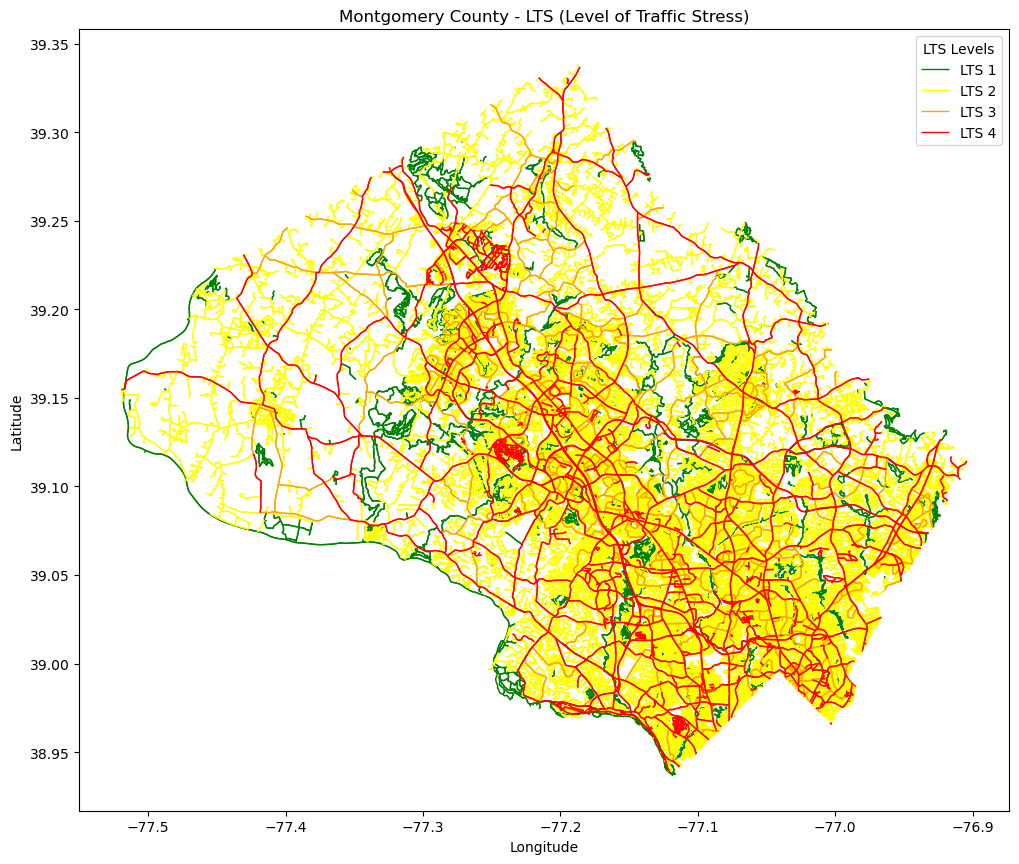

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your Montgomery County data into a GeoDataFrame (if not already loaded)
# gdf_edges = gpd.read_file('your_montgomery_county_data.shp')

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Define color mapping for LTS values
lts_colors = {
    1: 'green',   # Low-stress roads (LTS 1)
    2: 'yellow',  # Moderate-stress roads (LTS 2)
    3: 'orange',  # Higher-stress roads (LTS 3)
    4: 'red'      # High-stress roads (LTS 4)
}

# Plot each LTS level with a different color
for lts, color in lts_colors.items():
    gdf_edges[gdf_edges['LTS'] == lts].plot(ax=ax, color=color, linewidth=1, label=f'LTS {lts}')

# Add legend and title
plt.legend(title="LTS Levels")
plt.title("Montgomery County - LTS (Level of Traffic Stress)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

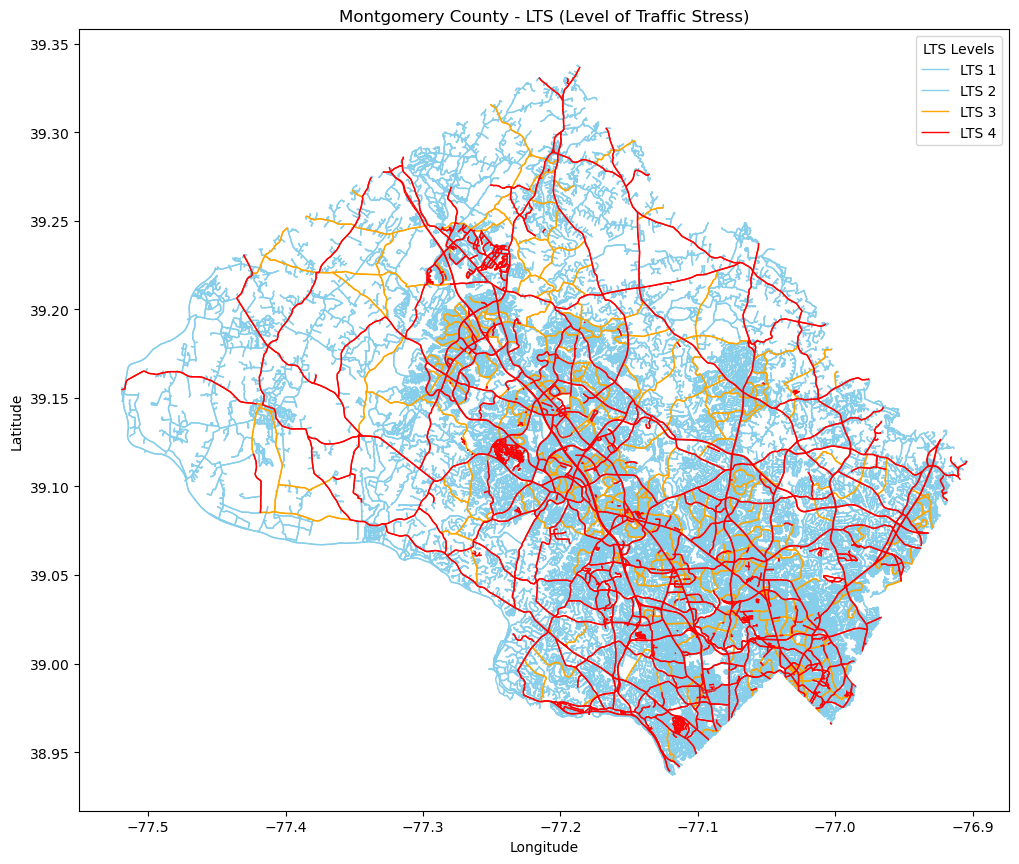

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your Montgomery County data into a GeoDataFrame (if not already loaded)
# gdf_edges = gpd.read_file('your_montgomery_county_data.shp')

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Define color mapping for LTS values
lts_colors = {
    1: 'skyblue',   # Low-stress roads (LTS 1)
    2: 'skyblue',  # Moderate-stress roads (LTS 2)
    3: 'orange',  # Higher-stress roads (LTS 3)
    4: 'red'      # High-stress roads (LTS 4)
}

# Plot each LTS level with a different color
for lts, color in lts_colors.items():
    gdf_edges[gdf_edges['LTS'] == lts].plot(ax=ax, color=color, linewidth=1, label=f'LTS {lts}')

# Add legend and title
plt.legend(title="LTS Levels")
plt.title("Montgomery County - LTS (Level of Traffic Stress)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()